# Figure X. Molecule Lineage Visualization

Import annotations.

In [312]:
import json
import zipfile
from io import TextIOWrapper

path = '../../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip'
with zipfile.ZipFile(path, 'r') as z:
    for filename in z.namelist()[200:201]:
        with z.open(filename) as file:
            with TextIOWrapper(file, encoding='utf-8') as text_file:
                result = json.load(text_file)

In [274]:
import pandas as pd

df = pd.DataFrame(result['annotations']).reindex(
    columns=['SMILES', 'Inspiration', 'Current Status', 'ABL1 pIC50', 'Log P', 'Log S'])

tested_adjacency = df[['Inspiration', 'SMILES']]
tested_adjacency = tested_adjacency.dropna().values

Get utility

In [275]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

df['utility'] = composite_utility_function(df[['ABL1 pIC50', 'Log P', 'Log S']].values, precompute=True, method='average')

Create partitions.

In [308]:
import igraph as ig

# Make graph
g = ig.Graph.TupleList(tested_adjacency, directed=True)

# Remove self-loops
g = g.simplify()

# Filter Tested molecules
vertices_to_include = set()
tested_smiles = df.query("`Current Status` == 'Tested'")['SMILES']
for tested_smiles_ in tested_smiles[::1]:
    if np.random.random() > 0.25: # remove a random fraction of nodes for easier plotting
        subcomponent = g.subcomponent(tested_smiles_, mode="IN")
        vertices_to_include.update(subcomponent)

g = g.subgraph(vertices_to_include)

Make colors based on utility.

In [334]:
vertices = g.get_vertex_dataframe()['name'].tolist()
scores = [df.query(f'`SMILES` == "{v}"')['utility'].iloc[0] for v in vertices]

# Step 2: Customize vertex colors and outlines
import seaborn as sns
palette = sns.color_palette("light:b", as_cmap=True)
vertex_colors = [palette(score) for score in scores]
vertex_frame_colors = ['white'] * len(vertex_colors)
vertex_frame_width = [1.0] * len(vertex_colors)

Function definitions.

In [331]:
def compress_x(x, y):
    medians = []
    for y_ in np.unique(y):
        indices_on_level = np.where(y == y_)
        median = np.median(x[indices_on_level].argsort().argsort())
        medians.append(median)

    center = max(medians)
    for y_ in np.unique(y):
        indices_on_level = np.where(y == y_)
        x[indices_on_level] = x[indices_on_level].argsort().argsort()
        x[indices_on_level] += center - np.median(x[indices_on_level])
        x[indices_on_level]
    
    return x, y

def cubic_bezier(p0, p1, p2, p3, t):
    """Compute the position on a cubic Bezier curve by parameter t."""
    return ((1 - t)**3 * np.array(p0) + 
            3 * (1 - t)**2 * t * np.array(p1) +
            3 * (1 - t) * t**2 * np.array(p2) + 
            t**3 * np.array(p3))

def plot_bezier(source, target, ax):
    
    # Process input
    offset = 0.25
    p0 = source
    p1 = np.array([source[0], source[1] - offset])
    p2 = np.array([target[0], target[1] + 0.15])
    p3 = target

    # Generate t values
    t_values = np.linspace(0, 1, 500)

    # Calculate the points on the Bezier curve
    bezier_points = np.array([cubic_bezier(p0, p1, p2, p3, t) for t in t_values])

    # Plotting the Bezier curve with control points
    ax.plot(
        bezier_points[:, 0],
        bezier_points[:, 1],
        label='Cubic Bezier Curve',
        color='grey',
        alpha=0.5,
        linewidth=0.25,
        zorder=-1000,
    )

def plot_bezier_edges(g, coord_dict, ax):

    for edge in g.get_edge_dataframe().itertuples():
        source = edge.source
        target = edge.target

        source_coords = coord_dict.get(source)
        target_coords = coord_dict.get(target)

        plot_bezier(source_coords, target_coords, ax)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


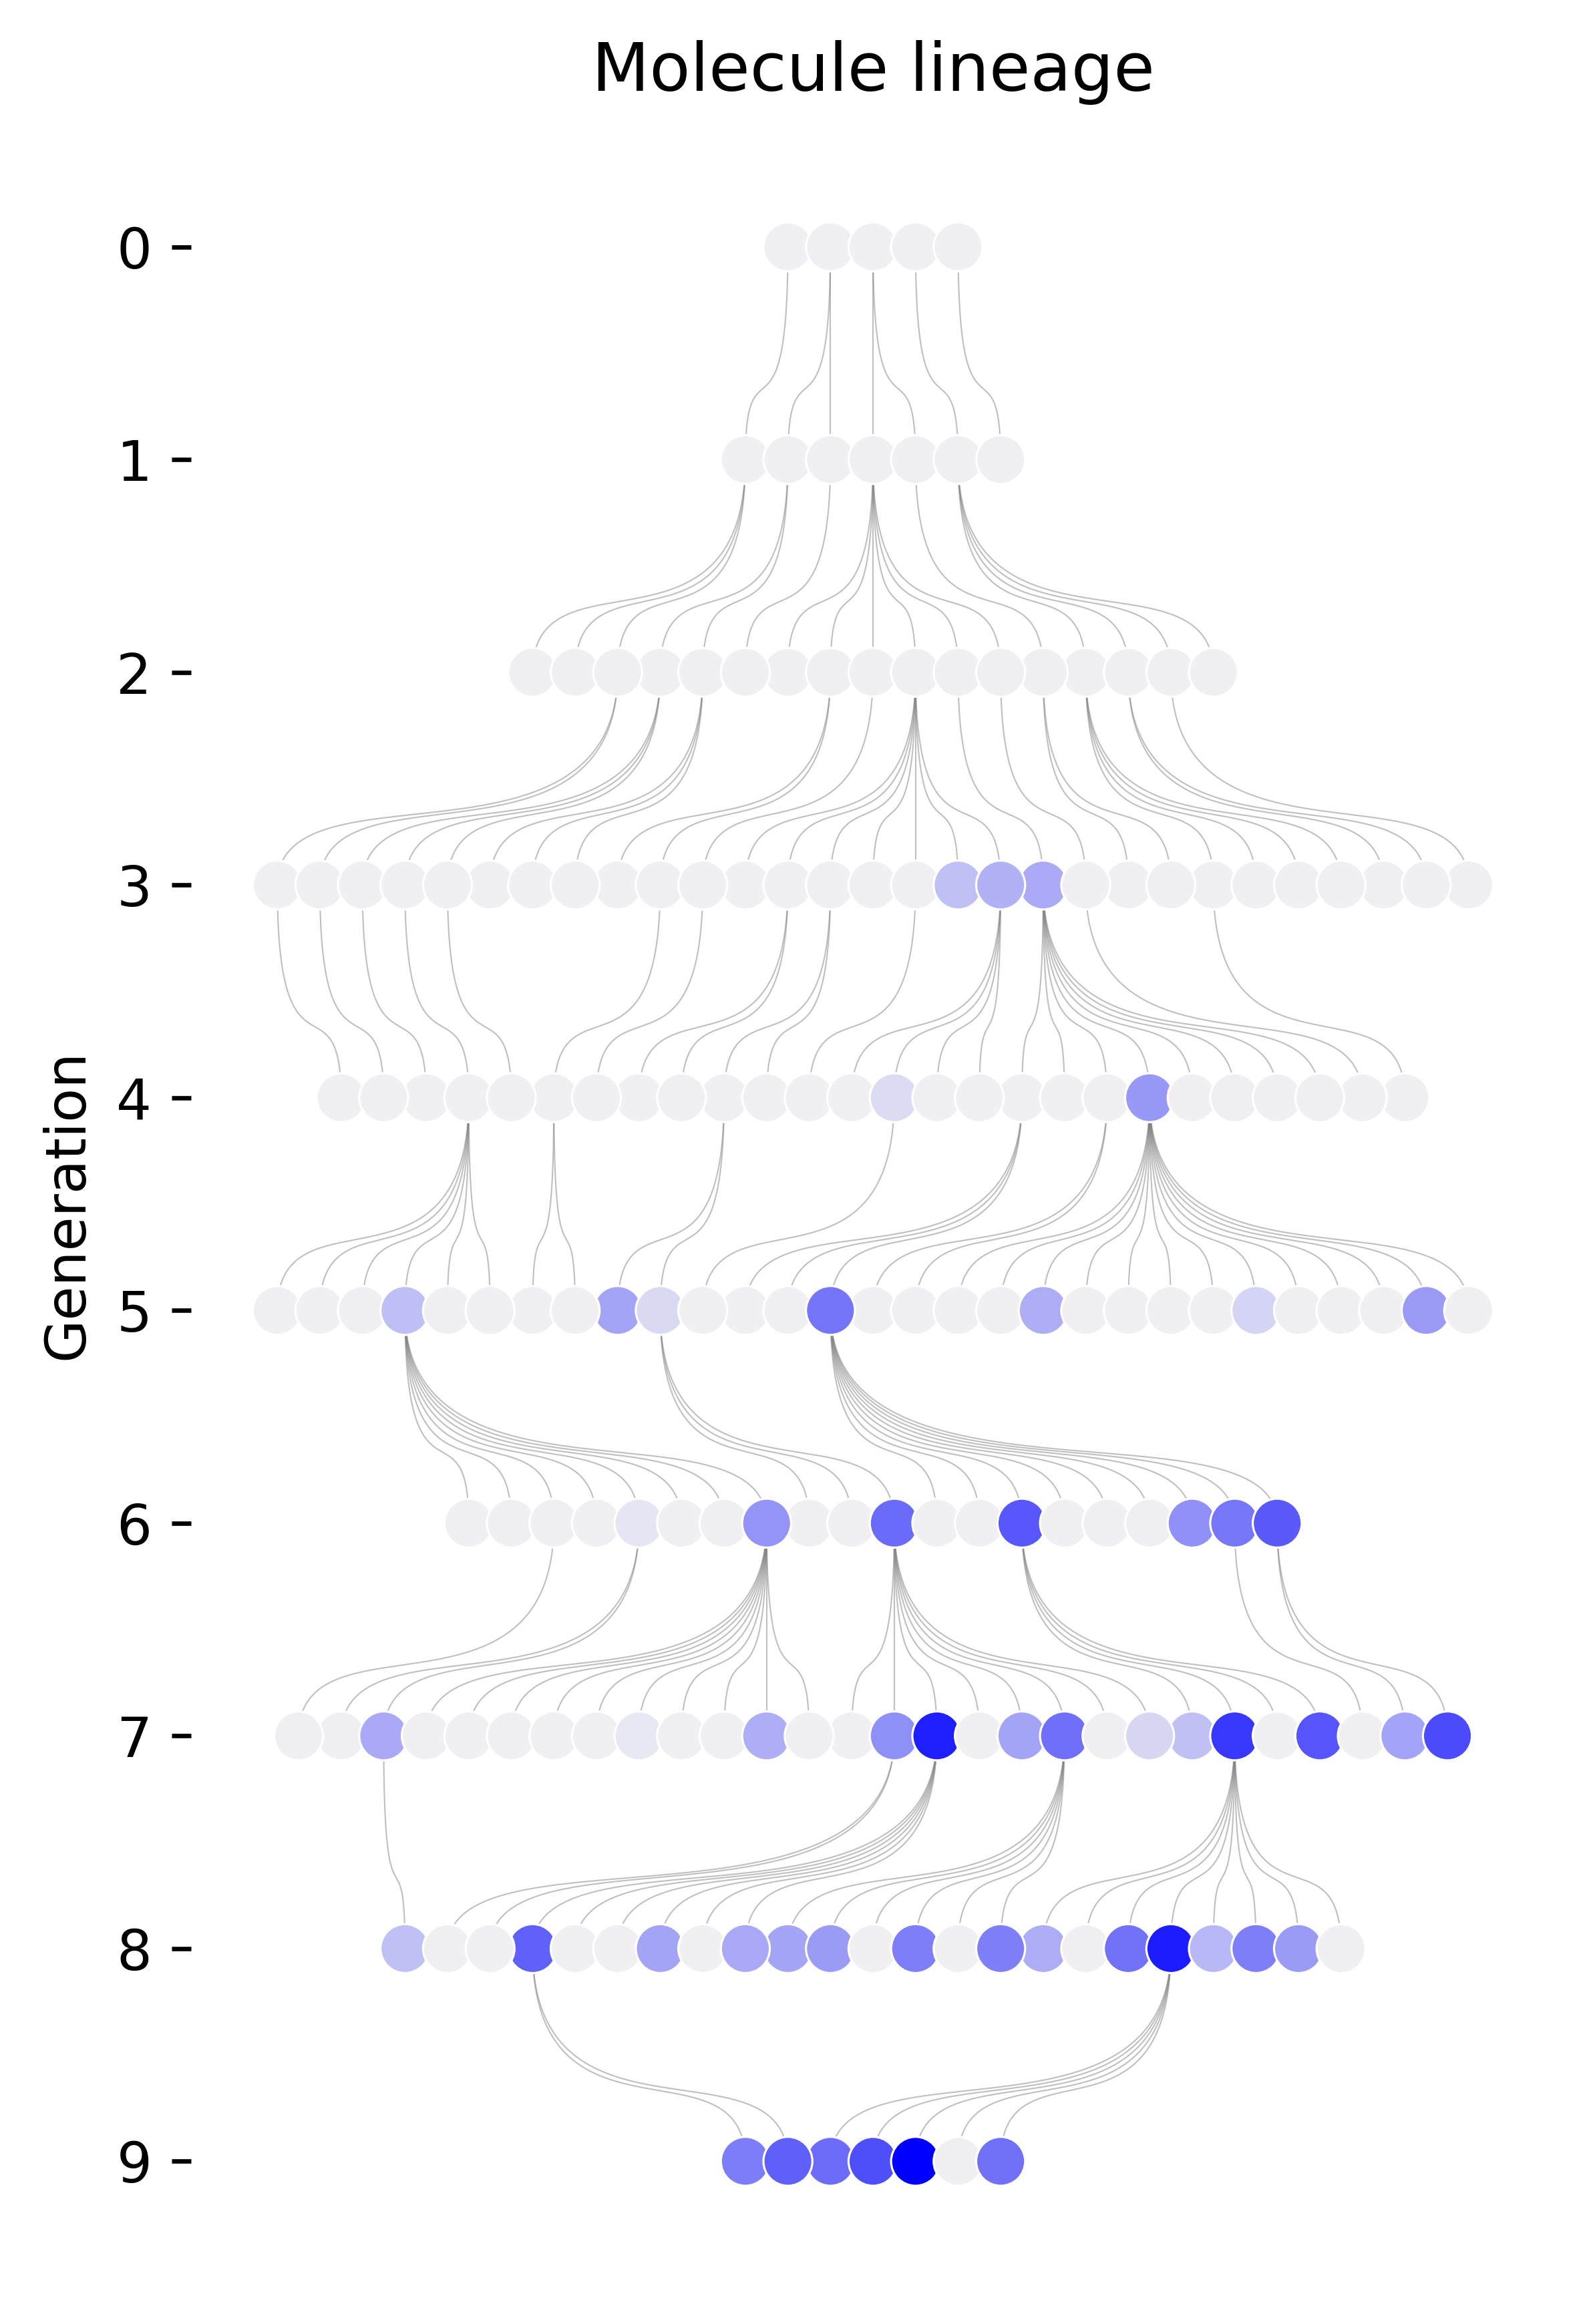

In [332]:
import numpy as np
from netgraph import Graph
import matplotlib.pyplot as plt

bezier = True
compress = True

coords = g.layout("rt")
x, y = np.array(coords.coords).T

if compress:
    x, y = compress_x(x, y)
    
x_scale = 20
y_scale = -4
x = np.array([x_ / x_scale for x_ in x])
y = np.array([y_ / y_scale for y_ in y])

coord_dict = {i: (x[i], y[i]) for i, _ in enumerate(vertices)}
color_dict = {i: vertex_colors[i] for i, _ in enumerate(vertices)}
edge_width = 0.0 if bezier else 0.2

fig, ax = plt.subplots(figsize=(12, 7), dpi=600)
Graph(
    g,
    node_layout=coord_dict,
    edge_width=edge_width,
    node_color=color_dict,
    node_edge_color='white',
    node_edge_width=0.25,
    ax=ax
)

if bezier:
    plot_bezier_edges(g, coord_dict, ax)

unique_y_ticks = np.unique(y)
ax.set_yticks(unique_y_ticks)
ax.set_yticklabels(reversed(range(len(unique_y_ticks))))
ax.set_ylabel('Generation')
ax.set_title('Molecule lineage')

plt.show()